## Introduction to FLARE: Fast Learning of Atomistic Rare Events
Jonathan Vandermause (jonathan_vandermause@g.harvard.edu)

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/flare_logo.png?raw=true" width="60%">

**Learning objectives:**
  * Train 2+3-body Gaussian process models on _ab initio_ force data.
  * Use the uncertainties of the GP to train a force field on the fly.

Computing the properties of real materials with quantum mechanical accuracy is extremely expensive. One of the most efficient explicitly quantum mechanical tools we have for the job, density functional theory (or DFT), has a computational cost that scales cubically with the number of atoms in the system, and is therefore limited in practice to at most a few hundred atoms (with some hope of scaling further with orbital free DFT methods).

One of the most popular strategies for getting around this is to simply ignore the hard part of the problem---the electrons---and to instead try to model the system with an _empirical interatomic potential_, which expresses the potential energy as a sum over local, atom-centered contributions that depend  only on atomic coordinates. The resulting model scales only linearly with the number of atoms, making it possible to simulate the behavior of hundreds of thousands or even millions of atoms over microsecond timescales. The problem then becomes: how do you design a good potential? Is it possible to find a fast empirical potential with the accuracy of DFT?

FLARE is an open-source software that uses Bayesian machine learning to try to bridge the gap between accurate but slow quantum methods (like DFT) and fast but inaccurate classical methods (like empirical interatomic potentials). The idea is to train fast potentials on accurate DFT data, and ideally to do so in an automatic, closed loop fashion, so that a wide class of materials and material compositions can be efficiently explored. The key tool FLARE uses to accomplish this is Gaussian process (GP) regression, an elegant framework for defining probability distributions over functions. In this tutorial, we'll explore the use of GPs to model interactions between atoms in materials.

If you're interested in learning more about the FLARE code, check out our [paper](https://www.nature.com/articles/s41524-020-0283-z), [GitHub page](https://github.com/mir-group/flare), and [code documentation](https://flare.readthedocs.io/en/latest/).



<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/md_review.png?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/flare_overview.png?raw=true" width="100%">

### Installation

We can install FLARE and its dependencies here in Google Colab. (This will take about a minute.)

In [ ]:
! pip install --upgrade mir-flare

Let's check that it worked by trying to import FLARE:

In [2]:
import flare

If you don't see an error, you're all set for the tutorial! Let's also go ahead and import all the modules we'll need now:

In [3]:
from flare import gp, struc, output, predict, md, otf, env,\
  otf_parser
from flare.kernels import mc_simple
from flare.utils import md_helper

import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
from ase.visualize import view

### Machine learned force fields

#### Training data

Let's start by downloading some _ab initio_ force data to play with.

In [ ]:
# download ab initio MD data
! wget https://zenodo.org/record/3688843/files/AgI_data.zip?download=1

# unzip the folder
! unzip AgI_data.zip?download=1

The folder "AgI_data" contains data from an _ab initio_ molecular dynamics simulation of the fast-ion conductor silver iodide (AgI), where _ab initio_ means "from the beginning" or "from first principles". In other words, we simulate how the atoms move by calculating the quantum mechanical forces on the ions at every timestep using DFT. To give you a sense of how expensive that is, the ~2500 timesteps in this simulation (about 12 picoseconds of simulation time) required 2 days of wall time on 256 cpus. (And there were only 32 atoms in the simulation!)

Let's load the positions, forces, cell, and species of the atoms in the simulation.

In [5]:
# load AIMD training data
data_directory = 'AgI_data/'
species = np.load(data_directory + 'species.npy')  # atomic numbers of the atoms
positions = np.load(data_directory + 'positions.npy')  # in angstrom (A)
cell = np.load(data_directory + 'cell.npy')  # 3x3 array of cell vectors (in A)
forces = np.load(data_directory + 'forces.npy')  # in eV/A

#### Training a GP model.

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/n_body.png?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/kernel.png?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/gpff.png?raw=true" width="100%">

Let's train a GP model on the data. We'll first initialize a Gaussian process object, which involves choosing a kernel function and its gradient, an initial set of hyperparameters, and the cutoff radii of local environments. We'll use a 2+3-body kernel, which compares local environments by comparing the pairs and triplets of atoms inside the environments.

In [6]:
# create a 2+3-body gaussian process object
kernels = ['twobody', 'threebody']
component = 'mc'
hyps = np.array([0.1, 0.1, 0.1, 2.0, 0.5])  # initial (bad) choice of hyps
cutoffs = {'twobody': 7.0, 'threebody': 5.5}  # cutoff radii in A
maxiter = 100  # max number of hyperparameter optimziation steps

gp_model = gp.GaussianProcess(
  kernels=kernels,
  component=component,
  hyps=hyps,
  cutoffs=cutoffs,
  maxiter=50
)

Let's put a couple of structures into the training set.

In [7]:
# put a few snapshots in the training set
snapshots = [500, 1500]
for snapshot in snapshots:
    # create flare structure
    training_positions = positions[snapshot]
    training_forces = forces[snapshot]
    training_structure = struc.Structure(cell, species, training_positions)

    # add the structure to the training set of the GP
    gp_model.update_db(training_structure, training_forces)

gp_model.set_L_alpha()

The "set_L_alpha" method updates the covariance matrix of the GP, computes the alpha vector used to make predictions, and computes the log marginal likelihood of the training data. Let's see what that looks like: 

In [8]:
print(gp_model.likelihood)

-491.75669961275526


This is too low, suggesting that our initial guess for the hyperparameters was not a good one.

#### Task: Find hyperparameters that give a positive log marginal likelihood.

Hint: For the 2+3-body kernel, the hyperparameters are in the following order:
* Signal variance of the 2-body kernel (in eV)
* Length scale of the 2-body kernel (in A)
* Signal variance of the 3-body kernel (in eV)
* Length scale of the 3-body kernel (in A)
* Noise hyperparameter (in eV/A)

What is a plausible length scale for this problem? Note that machine learned force fields typically have errors in the range 50-200 meV/A, and the energy of a pair or triplet is much less than the total local energy assigned to an atom.

In [ ]:
# your code here

# hint: reset the hyperparameters with gp_model.hyps = *new hyps*, then use
# set_L_alpha to recompute the likelihood

#### Solution

A reasonable guess for the length scale is 1 A, and since errors are  often around 0.1 eV/A, we'll choose that as our noise level. The signal variances require some tuning, but we should expect them to be significantly less than 1 eV, with the triplet contribution significantly smaller than the pair contribution.

In [9]:
gp_model.hyps = np.array([0.01, 1, 0.001, 1, 0.2])
gp_model.set_L_alpha()
print(gp_model.likelihood)

9.500574018895804


#### Optimizing the hyperparameters rigorously

The above was an exercise in manual hyperparameter tuning, which is tedious and should be avoided if possible. Because we can compute the gradient of the likelihood with respect to the hyperparameters, we can instead use a more principled gradient descent approach to find the best set of hyperparameters.

In [ ]:
# optimize the hyperparameters (this will take some time!)
gp_model.train(print_progress=True)

In case you don't want to wait, here are some good values:

In [10]:
gp_model.hyps = np.array([1.59612454e-02, 5.70104540e-01, 6.01290125e-04,
                          9.17243358e-01, 1.09666317e-01])
gp_model.set_L_alpha()
print(gp_model.likelihood)

71.16991245736048


#### Calculating the learning curve

Let's get a feel for how much data the model needs by computing the learning curve, i.e. the performance on a validation set as a function of the number of training points. Let's create training and validation structures drawn from the AIMD simulation.

In [11]:
# choose a training snapshot
training_snapshot = 500
training_positions = positions[training_snapshot]
training_forces = forces[training_snapshot]
training_structure = struc.Structure(cell, species, training_positions)

# choose a validation snapshot
validation_snapshot = 2300
validation_positions = positions[validation_snapshot]
validation_forces = forces[validation_snapshot]
validation_structure = struc.Structure(cell, species, validation_positions)

We now loop over the atomic environments in the training structure and add them one by one to the training set of the GP model. After adding an environment, we predict all the forces on the validation structure and compute the MAE. We'll also time the prediction step to get a feel for how the cost of GP predictions depends on the size of the training set.

In [12]:
# reset the gp with hyperparameters fixed to the optimized values
hyps_final = gp_model.hyps
gp_model = gp.GaussianProcess(
  kernels=kernels,
  component=component,
  hyps=hyps,
  cutoffs=cutoffs,
  maxiter=50
)
gp_model.hyps = hyps_final

# add atomic environments one by one to the training set
n_atoms = 32  # number of atoms in the structure
validation_errors = np.zeros(n_atoms)
prediction_times = np.zeros(n_atoms)
validation_count = 0

print('computing validation errors...')
for n, atom in enumerate(range(n_atoms)):
    # add the current atomic environment to the training set
    gp_model.update_db(training_structure, training_forces,
                        custom_range=[atom])
    gp_model.set_L_alpha()

    # predict the forces on the validation structure
    time0 = time.time()
    pred_forces, stds = \
        predict.predict_on_structure(validation_structure, gp_model)
    time1 = time.time()

    mae = np.mean(np.abs(pred_forces - validation_forces))
    validation_errors[validation_count] = mae
    prediction_times[validation_count] = time1 - time0
    validation_count += 1

    print(mae)

computing validation errors...
0.315073761272364
0.29588515439108337
0.3234313322939279
0.29323785059806706
0.20129532813447323
0.19131142668143372
0.1827709765647784
0.17610478136490326
0.16902120241436183
0.17466172091548085
0.16829757387913633
0.16823160886145053
0.1797266370933175
0.17570045468126091
0.1778018841113225
0.16181457527423726
0.15221658747132247
0.151463002400943
0.15330262545396417
0.14366990594229426
0.13955981466966869
0.1386958938185947
0.13337032134291107
0.13856470639127907
0.13934854695295343
0.1384439054077334
0.1376182149699538
0.1398980197468981
0.13878505117526346
0.13947592439212986
0.14140188721074384
0.14095157040791634


Let's make a plot of the results.

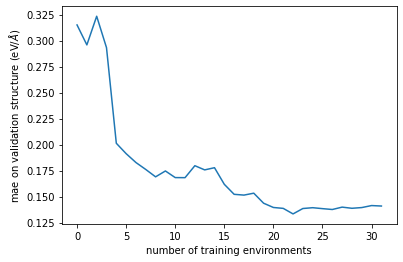

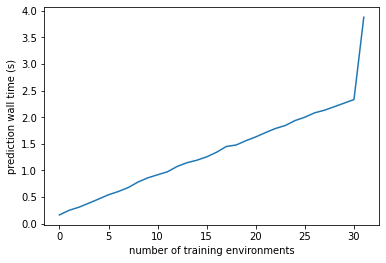

In [13]:
plt.plot(validation_errors)
plt.xlabel('number of training environments')
plt.ylabel('mae on validation structure (eV/$\AA$)')
plt.show()

plt.plot(prediction_times)
plt.xlabel('number of training environments')
plt.ylabel('prediction wall time (s)')
plt.show()

Notice that the prediction time grows roughly linearly with the number of training environments.

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/pd_ag_1.png?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/pd_ag_2.png?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/pd_ag_3.png?raw=true" width="100%">

### Learning a force field on the fly

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/flowchart.png?raw=true" width="70%">

#### The Lennard Jones Potential

In production FLARE runs, we make calls to a DFT solver like Quantum Espresso, VASP, or CP2K whenever the uncertainty on a force component is unacceptably high. In principle, the forces can come from anywhere, and FLARE allows users to write a custom solver that returns forces on an arbitrary input structure.

Here, we'll define a simple custom solver that returns Lennard Jones forces, and then try to reconstruct the potential on the fly.

The Lennard Jones potential takes the following form:
\begin{equation}
V_{\text{LJ}} = 4\epsilon \left[ \left(\frac{\sigma}{r} \right)^{12} - \left(\frac{\sigma}{r}\right)^{6} \right].
\end{equation}

Let's define our custom solver. To do this, we need to create a class with two methods:

* parse_dft_input: Takes the name of an input file, and returns the positions, species, cell, and masses of the atoms specified in the input file.

* run_dft_par: Takes a FLARE structure and an optional dictionary of keywords, and returns the forces on the atoms.

We'll make a multi-species Lennard Jones function, which allows different values of $\sigma$ and $\epsilon$ for different pairs of species. We'll store these as 2-D numpy arrays, so that, e.g., the $\sigma$ value assigned to species 1 and 3 is stored in element (1, 3) of this array.

The derivative of the Lennard Jones potential with respect to $r$ is:

\begin{equation}
\frac{dV_{\text{LJ}}}{dr} = 4\epsilon \left[ -\frac{12 \sigma^{12}}{r^{13}} +\frac{6 \sigma^6}{r^7} \right].
\end{equation}

In [14]:
def get_LJ_forces(structure, lj_parameters):
  """Calculate multicomponent Lennard Jones forces on a structure of atoms.
  dft_kwargs is assumed to be a dictionary containing the cutoff, an ordered
  list of species, and arrays containing epsilon and sigma values."""

  cutoff = lj_parameters['cutoff']
  epsilons = lj_parameters['epsilons']
  sigmas = lj_parameters['sigmas']
  spec_list = lj_parameters['species']

  forces = np.zeros((structure.nat, 3))
  # Loop over atoms in the structure.
  for m in range(structure.nat):
      # Create atomic environment.
      environment = env.AtomicEnvironment(structure, m, np.array([cutoff]))
      ind1 = spec_list.index(environment.ctype)

      # Loop over atoms in the environment to compute the total force.
      for n in range(len(environment.etypes)):
          ind2 = spec_list.index(environment.etypes[n])
          eps = epsilons[ind1, ind2]
          sig = sigmas[ind1, ind2]

          # Compute LJ force.
          bond_vals = environment.bond_array_2[n]
          r = bond_vals[0]

          dE_dr = 4 * eps * (-12 * sig ** 12 / (r ** 13) +
                             6 * sig ** 6 / (r ** 7))

          forces[m, 0] += dE_dr * bond_vals[1]
          forces[m, 1] += dE_dr * bond_vals[2]
          forces[m, 2] += dE_dr * bond_vals[3]

  return forces

We can use our Lennard Jones force function to define a custom module.

In [15]:
# create lj module
class lj_module:
  def parse_dft_input(file_name):
      """We assume the input is a pickled dictionary containing positions
      (in angstrom), species (as a list of strings), cell (as a 3x3 matrix of
      cell vectors), and masses (as a dictionary assigning each species a mass
      in AMU)."""

      input_file = open(file_name, 'rb')
      struc_dict = pickle.load(input_file)
      input_file.close()

      # Convert masses to MD units (energy = eV, length = A, )
      masses = struc_dict['masses']
      mass_convert = 0.000103642695727
      for species in masses:
          masses[species] *= mass_convert

      return struc_dict['positions'], struc_dict['species'], \
          struc_dict['cell'], masses

  def run_dft_par(dft_input=None, structure=None, dft_loc=None, n_cpus=None,
                npool=None, mpi=None, dft_kwargs=None, dft_out=None):
    return get_LJ_forces(structure, dft_kwargs)

In [16]:
# create dictionary of lj parameters
cutoff = 5.
epsilons = np.array([[3, 2.5], [2.5, 3.]])
sigmas = np.array([[2.0, 1.9], [1.9, 2.1]])
spec_list = [47, 53]  # silver and iodine atomic numbers

lj_params = {'cutoff': cutoff, 'epsilons': epsilons, 'sigmas': sigmas,
             'species': spec_list}

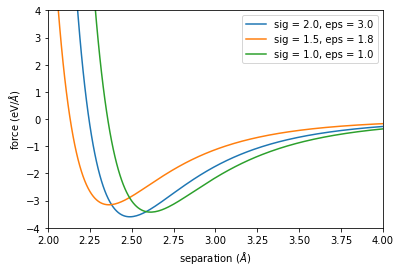

In [17]:
# create structures of 2 atoms, and plot the force on the second atom
cell = np.eye(3) * 1000
seps = np.arange(2, 5, 0.01)
specs = [[47, 47], [47, 53], [53, 53]]
store_frcs = np.zeros((3, len(seps)))
for m, sep in enumerate(seps):
    pos = np.array([[0, 0, 0], [sep, 0, 0]])
    for n, spec_curr in enumerate(specs):
        struc_curr = struc.Structure(cell, spec_curr, pos)
        frcs = \
            lj_module.run_dft_par(structure=struc_curr, dft_kwargs=lj_params)
        store_frcs[n, m] = frcs[1, 0]

plt.plot(seps, store_frcs[0], label='sig = 2.0, eps = 3.0')
plt.plot(seps, store_frcs[1], label='sig = 1.5, eps = 1.8')
plt.plot(seps, store_frcs[2], label='sig = 1.0, eps = 1.0')
plt.xlim(2, 4)
plt.ylim(-4, 4)
plt.xlabel('separation ($\AA$)')
plt.ylabel('force (eV/$\AA$)')
plt.legend()
plt.show()

#### Perform an on-the-fly training simulation.

#### Step 1: Set up the initial structure.

 Let's create a bcc (body centered cubic) Lennard Jones crystal.

In [18]:
# create bcc unit cell
alat = 2.54
unit_cell = np.eye(3) * alat

# define bcc positions
unit_positions = np.array([[0, 0, 0],
                           [1/2, 1/2, 1/2]]) * alat

# make a supercell
sc_size = 3
positions = md_helper.get_supercell_positions(sc_size, unit_cell, unit_positions)
cell = unit_cell * sc_size

# jitter positions to give nonzero force on first frame
for atom_pos in positions:
    for coord in range(3):
        atom_pos[coord] += (2*np.random.random()-1) * 0.05

# create initial structure
species = ['Ag', 'I'] * sc_size ** 3
struc_curr = struc.Structure(cell, species, positions)

# create pseudo input file
mass_dictionary = {'Ag': 108, 'I': 127}
input_dictionary = {'positions': positions, 'species': species, 'cell': cell,
                    'masses': mass_dictionary}
input_file_name = 'lj.in'
with open(input_file_name, 'wb') as input_file:
    pickle.dump(input_dictionary, input_file)

In [19]:
# view the structure 
view(struc_curr.to_ase_atoms(), viewer='x3d')

#### Step 2: Set up a GP model.

In [20]:
# create gaussian process model
kernels = ['twobody']
component = 'mc'
hyps = np.array([0.1, 1., 0.06])
hyp_labels = ['Sigma', 'Length Scale', 'Noise']
cutoffs = {'twobody': 5.0}
maxiter = 50

gp_model = gp.GaussianProcess(
  kernels=kernels,
  component=component,
  hyps=hyps,
  hyp_labels=hyp_labels,
  cutoffs=cutoffs,
  maxiter=50
)

#### Step 3: Set up an OTF training object.

In [21]:
# create otf object
dt = 0.001  # time step (ps)
number_of_steps = 50
dft_loc = None  # path to dft executable would usually go here
std_tolerance_factor = -0.01  # 10 meV/A
init_atoms = [0, 25, 50]  # initial atoms added to the training set
max_atoms_added = 5  # number of atoms added when dft is called
freeze_hyps = 5  # no hyperparameter optimization after this many updates

# rescale the temperature halfway through the simulation
rescale_steps = [10]  # rescale at step 10
rescale_temps = [1000]
  
otf_model = otf.OTF(
    # MD arguments
    dt,
    number_of_steps,
    rescale_steps=rescale_steps,
    rescale_temps=rescale_temps,
    # FLARE arguments
    gp=gp_model,
    # OTF arguments
    std_tolerance_factor=std_tolerance_factor,
    init_atoms=init_atoms,
    max_atoms_added=max_atoms_added,
    freeze_hyps=freeze_hyps,
    # DFT arguments
    force_source=lj_module,
    dft_loc=dft_loc,
    dft_input=input_file_name,
    dft_kwargs=lj_params
    )

#### Step 4: Perform the simulation!

In [22]:
# perform flare run (this will take about 2.5 minutes)
otf_model.run()

#### Parsing the OTF output file.

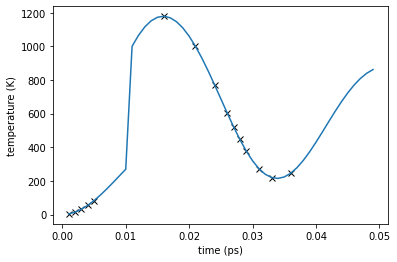

In [23]:
# parse output file
output_file = 'otf_run.out'
otf_trajectory = otf_parser.OtfAnalysis(output_file)

# plot temperature vs. simulation time
times = otf_trajectory.times
temps = otf_trajectory.thermostat['temperature']
dft_times = otf_trajectory.dft_times[1:]  # exclude t = 0

for n, dft_time in enumerate(dft_times):
    otf_ind = times.index(dft_time)
    plt.plot(dft_times[n], temps[otf_ind], 'kx')

plt.plot(times, temps)
plt.xlabel('time (ps)')
plt.ylabel('temperature (K)')
plt.show()

#### Comparing the learned model against ground truth.

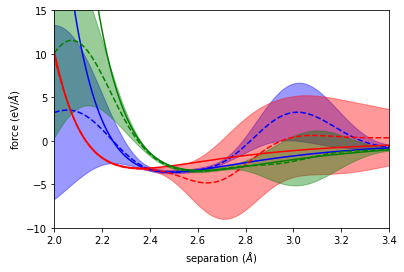

In [24]:
# create structures of 2 atoms, and plot the force on the second atom
cell = np.eye(3) * 1000
seps = np.arange(2, 5, 0.01)
specs = [[47, 47], [47, 53], [53, 53]]
store_frcs = np.zeros((3, len(seps)))
gp_frcs = np.zeros((3, len(seps)))
gp_stds = np.zeros((3, len(seps)))
for m, sep in enumerate(seps):
    pos = np.array([[0, 0, 0], [sep, 0, 0]])
    for n, spec_curr in enumerate(specs):
        struc_curr = struc.Structure(cell, spec_curr, pos)
        env_curr = env.AtomicEnvironment(struc_curr, 1, np.array([cutoff]))
        frcs = \
            lj_module.run_dft_par(structure=struc_curr, dft_kwargs=lj_params)
        store_frcs[n, m] = frcs[1, 0]

        # predict the x component of the force
        pred, var = gp_model.predict(env_curr, 1)

        gp_frcs[n, m] = pred
        gp_stds[n, m] = np.sqrt(var)

# plot GP predictions vs ground truth
cols = ['b', 'r', 'g']
for n in range(3):
    plt.plot(seps, store_frcs[n], color=cols[n], linestyle='-')
    plt.plot(seps, gp_frcs[n], color=cols[n], linestyle='--')
    plt.fill_between(seps, gp_frcs[n] + 3 * gp_stds[n],
                     gp_frcs[n] - 3 * gp_stds[n],
                     color=cols[n], alpha=0.4)

plt.xlabel('separation ($\AA$)')
plt.ylabel('force (eV/$\AA$)')
plt.xlim(2, 3.4)
plt.ylim(-10, 15)
plt.show()

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/flare1.png?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/flare2.png?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/flare3.png?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/flare4.png?raw=true" width="100%">

<img src="https://github.com/mir-group/APS-2020-FLARE-Tutorial/blob/master/Tutorial_Images/conclusion.png?raw=true" width="100%">